In [1]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from timeit import default_timer as timer
import os
from PIL import Image
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import zipfile

path_to_zip_file = '/content/data.zip'

directory_to_extract_to = '/content/data_temp'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [48]:
def get_lengths(dir_path):
    dataset_info = {}
    for dirpath, dirnames, filenames in os.walk(dir_path):
        emotion_name = dirpath.split('/')[-1]
        dataset_info[emotion_name] = len(filenames)
    del dataset_info[dir_path.split('/')[-1]]
    return dataset_info

train_info = get_lengths('/content/data_temp/data/train')
val_info = get_lengths('/content/data_temp/data/test')

In [49]:
train_dir = "/content/data_temp/data/train"
val_dir = "/content/data_temp/data/test"

# Distributions

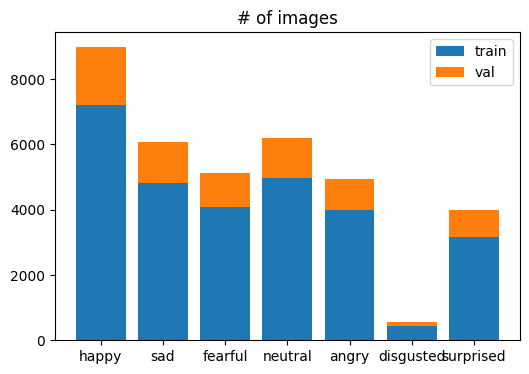

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(train_info.keys(), train_info.values(), label='train')
plt.bar(val_info.keys(), val_info.values(), label='val', bottom=list(train_info.values()))
plt.title('# of images')
plt.legend();

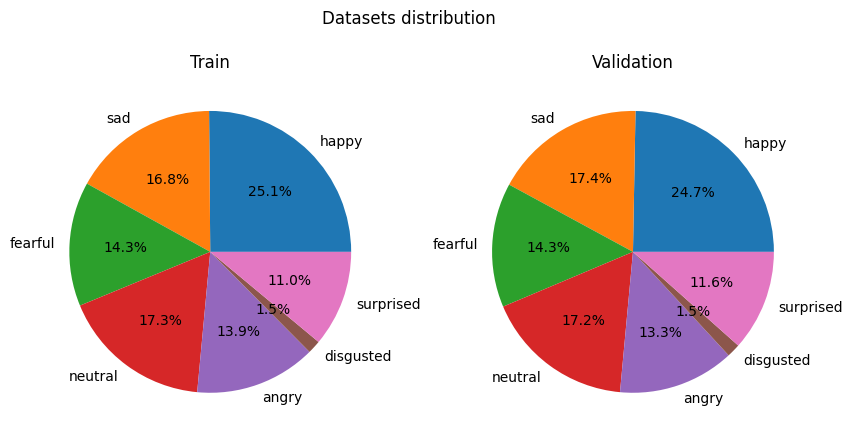

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.pie(train_info.values(), labels=train_info.keys(), autopct='%1.1f%%')
plt.title('Train')

plt.subplot(122)
plt.pie(val_info.values(), labels=val_info.keys(), autopct='%1.1f%%')
plt.title('Validation')

plt.suptitle('Datasets distribution');

# Sample images

Random image path: /content/data_temp/data/train/surprised/im2508.png
Random image class: surprised
Image height: 48
Image width: 48


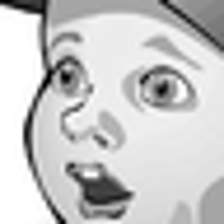

In [50]:
def show_random_image(images_path,
                      seed=None):
    """
    Shows one random photo with details such as class, heigh, width
    """
    
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    return image.resize((224, 224))

input_folder = Path('/content/data_temp/data')
image_path_list = list(input_folder.glob("*/*/*"))
show_random_image(image_path_list, 0)

# Transformation

In [51]:
train_transform = transforms.Compose([
     transforms.Grayscale(),
     transforms.Resize(size=(48, 48)),
     transforms.RandomHorizontalFlip(),
    #  transforms.RandomRotation(90),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))
])

val_transform = transforms.Compose([
     transforms.Grayscale(),
     transforms.Resize(size=(48, 48)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5)),
])

# Data preparation

In [52]:
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform)

In [53]:
batch_size = 128

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

# Model

In [54]:
emotion_features = len(val_dataset.classes)

In [88]:
class MultilabelCNN(nn.Module):
    def __init__(self, target_features):
        super().__init__()
        
        self.CNNModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #24
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #12
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #6
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #3
            nn.Dropout(0.1),
            nn.AdaptiveAvgPool2d((1,1)), #flatten
            nn.Flatten()
            # nn.LeakyReLU()
        )

        self.DNNModel = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Dropout(0.4), 
            nn.Linear(64, 32),
            nn.Dropout(0.1), 
            nn.LeakyReLU())
        
        self.target_layer = nn.Linear(32, target_features)
        
    def forward(self, x):
        output = self.CNNModel(x).squeeze()
        output = self.DNNModel(output)

        pred = self.target_layer(output)
        
        return pred

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
device

device(type='cuda')

In [36]:
# summary(model_emotion, input_size=(1, 48, 48))

# Train loop

In [58]:
def train_step(model, 
               dataloader,
               loss_function,
               optimizer,
               device):
    
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (image, y) in enumerate(dataloader):        

        image, y = image.to(device), y.to(device)

        y_pred = model(image)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [59]:
def val_step(model, 
             dataloader,
             loss_function, 
             device):
    
    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []
    
    with torch.inference_mode():
        for batch, (image, y) in enumerate(dataloader):
            image, y = image.to(device), y.to(device)

            y_pred = model(image)

            loss = loss_function(y_pred, y)
            val_loss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            val_acc += (y_pred_class == y).sum().item() / len(y)
            
            y_preds.append(y_pred_class.cpu())
            
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    
    y_pred_tensor = torch.cat(y_preds)
    return val_loss, val_acc, y_pred_tensor

In [60]:
def train(model, 
          train_dataloader,
          val_dataloader,
          loss_function,
          optimizer,
          epochs, 
          device):
    
    results = {'train_loss': [], 
               'train_acc': [], 
               'val_loss': [], 
               'val_acc': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc, y_preds = val_step(model=model, 
                                              dataloader=val_dataloader,
                                              loss_function=loss_function,
                                              device=device)
        
        print(f'Epoch: {epoch+1} , Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')
        print(f'Train accuracy: {train_acc:.3f}, Validation accuracy: {val_acc:.3f}')
        print()
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        
    return results, y_preds

# Running model

## Emotion model

In [92]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 60

loss_function = nn.CrossEntropyLoss()

model_emotion = MultilabelCNN(emotion_features).to(device)

optimizer = torch.optim.Adam(params=model_emotion.parameters(), lr=3e-4, weight_decay=1e-5)

start_timer = timer()

model_results, preds = train(model=model_emotion, 
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             loss_function=loss_function,
                             optimizer=optimizer,
                             epochs=epochs,
                             device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 , Train loss: 1.858, Validation loss: 1.835
Train accuracy: 0.215, Validation accuracy: 0.243

Epoch: 2 , Train loss: 1.810, Validation loss: 1.809
Train accuracy: 0.241, Validation accuracy: 0.250

Epoch: 3 , Train loss: 1.789, Validation loss: 1.781
Train accuracy: 0.258, Validation accuracy: 0.266

Epoch: 4 , Train loss: 1.751, Validation loss: 1.736
Train accuracy: 0.281, Validation accuracy: 0.298

Epoch: 5 , Train loss: 1.678, Validation loss: 1.625
Train accuracy: 0.319, Validation accuracy: 0.350

Epoch: 6 , Train loss: 1.612, Validation loss: 1.539
Train accuracy: 0.350, Validation accuracy: 0.388

Epoch: 7 , Train loss: 1.541, Validation loss: 1.484
Train accuracy: 0.383, Validation accuracy: 0.417

Epoch: 8 , Train loss: 1.492, Validation loss: 1.461
Train accuracy: 0.404, Validation accuracy: 0.413

Epoch: 9 , Train loss: 1.450, Validation loss: 1.412
Train accuracy: 0.426, Validation accuracy: 0.444

Epoch: 10 , Train loss: 1.428, Validation loss: 1.380
Train accu

### Saving model

In [99]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Emotions/'

torch.save(model_emotion, PATH+'model emotion.pt')

### Loss & accuracy

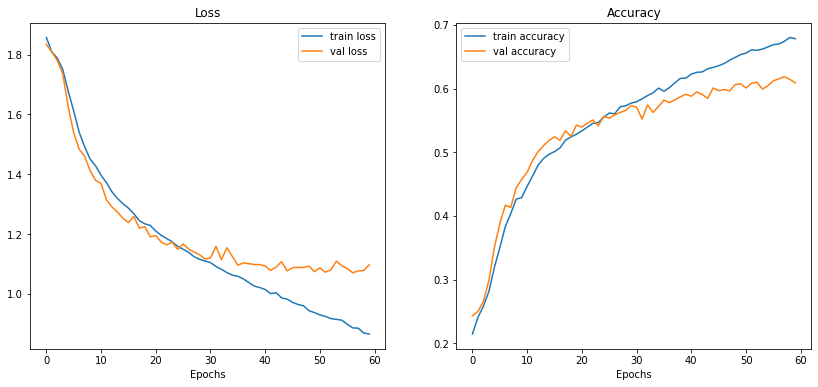

In [94]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(np.arange(len(model_results['train_loss'])), model_results['train_loss'], label='train loss')
plt.plot(np.arange(len(model_results['val_loss'])), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(len(model_results['train_acc'])), model_results['train_acc'], label='train accuracy')
plt.plot(np.arange(len(model_results['val_acc'])), model_results['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

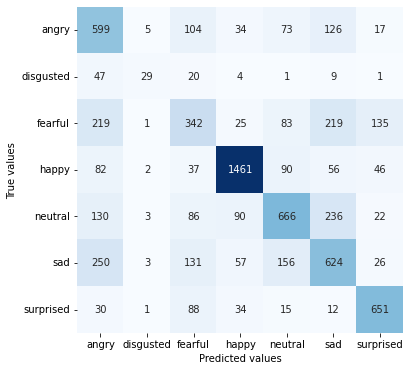

In [95]:
import seaborn as sns

cm = confusion_matrix(val_dataset.targets, preds)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, cbar=False, cmap='Blues', square=True, annot=True, fmt='')
plt.xticks(np.arange(0.5, 7.5, 1), val_dataset.classes)
plt.yticks(np.arange(0.5, 7.5, 1), val_dataset.classes, rotation=0)
plt.xlabel('Predicted values')
plt.ylabel('True values');

# Experimenting with other images

In [65]:
from PIL import Image

In [70]:
emotion_labels = {i:train_dataset.classes[i] for i in range(len(train_dataset.classes))}

In [73]:
def predict_aeg(path, model_emotion, labels):
    face = Image.open(path)

    height = face.height
    width = face.width
    ratio = height / width

    transform = transforms.Compose([
              transforms.Grayscale(),
              transforms.Resize((48, 48)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.5], std=[0.5]),
          ])
    
    transformed_face = transform(face)

    pred_emotion = model_emotion(transformed_face.to(device))

    pred_emotion = torch.argmax(pred_emotion).item()

    print(f'Emotion: {labels[pred_emotion]}')
    print()
    display(transforms.Resize((int(400*ratio), 400))(face))

Emotion: surprised



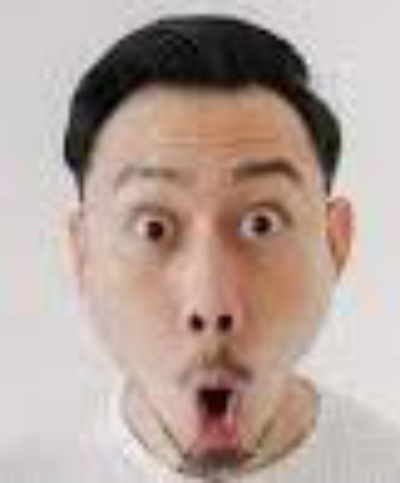

In [100]:
predict_aeg('image.jpeg', model_emotion, emotion_labels)